In [2]:
%matplotlib inline
import os
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import numpy as np
from glob import glob
import seaborn as sns

In [8]:
BASE_DATA_FOLDER = 'data\\'
TRAin_DATA_FOLDER = os.path.join(BASE_DATA_FOLDER, 'train\\train\\')

In [12]:
images_per_class = {}
for class_folder_name in os.listdir(TRAin_DATA_FOLDER):
    class_folder_path = os.path.join(TRAin_DATA_FOLDER, class_folder_name)
    class_label = class_folder_name
    images_per_class[class_label] = []
    for image_path in glob(os.path.join(class_folder_path, "*.png")):
        image_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
        images_per_class[class_label].append(image_bgr)

for key,value in images_per_class.items():
    print("{0} -> {1}".format(key, len(value)))


Shepherds Purse -> 231
Common Chickweed -> 611
Common wheat -> 221
Maize -> 221
Loose Silky-bent -> 654
Sugar beet -> 385
Black-grass -> 263
Small-flowered Cranesbill -> 496
Cleavers -> 287
Scentless Mayweed -> 516
Charlock -> 390
Fat Hen -> 475


In [13]:
def plot_for_class(label):
    nb_rows = 3
    nb_cols = 3
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(6, 6))

    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].xaxis.set_ticklabels([])
            axs[i, j].yaxis.set_ticklabels([])
            axs[i, j].imshow(images_per_class[label][n])
            n += 1

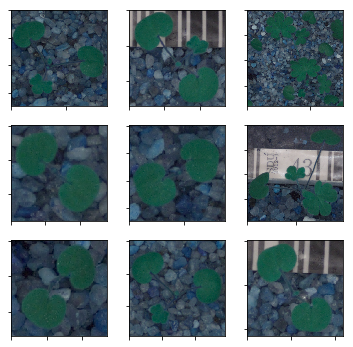

In [14]:
plot_for_class("Small-flowered Cranesbill")

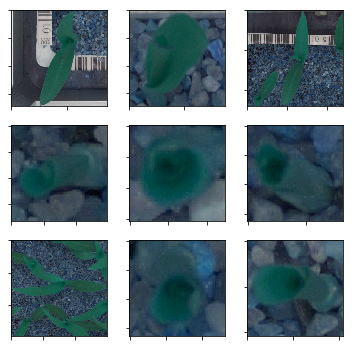

In [15]:
plot_for_class("Maize")

In [16]:
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

def segment_plant(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output

def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

The create_mask_for_plant function: This function returns an image mask: Matrix with shape (image_height, image_width). In this matrix there are only 0 and 1 values. The 1 values define the interesting part of the original image. But the question is...How do we create this mask?

This is a simple object detection problem, where we can use the color of the object.

The HSV color-space is suitable for color detection because with the Hue we can define the color and the saturation and value will define "different kinds" of the color. (For example it will detect the red, darker red, lighter red too). We cannot do this with the original BGR color space

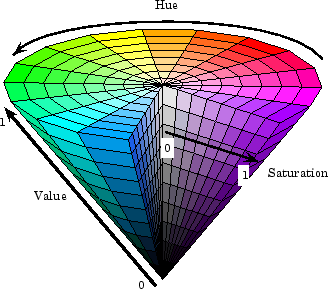
image from https://www.mathworks.com/help/images/convert-from-hsv-to-rgb-color-space.html

We have to set a range, which color should be detected:

After the mask is created with the inRange function, we can do a little CV magic (not close to magic, because this is almost the most basic thing in CV, but it is a cool buzzword, and this opertation is as awesome as simple it is) which is called morphological operations (You can read more here).

Basically with the Close operation we would like to keep the shape of the original objects (1 blobs on the mask image) but close the small holes. That way we can clarify our detection mask more.

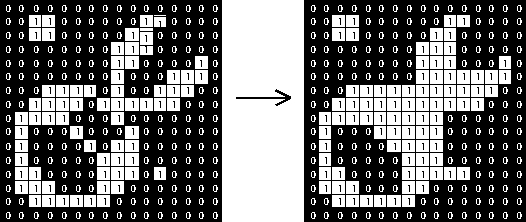

image from https://www.cs.auckland.ac.nz/courses/compsci773s1c/lectures/ImageProcessing-html/topic4.htm

After these steps we created the mask for the object.

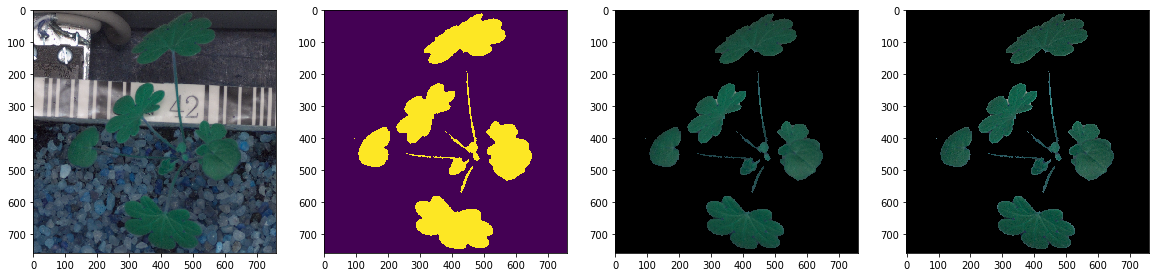

In [18]:
# Test image to see the changes
image = images_per_class["Small-flowered Cranesbill"][97]

image_mask = create_mask_for_plant(image)
image_segmented = segment_plant(image)
image_sharpen = sharpen_image(image_segmented)

fig, axs = plt.subplots(1, 4, figsize=(20, 20))
axs[0].imshow(image)
axs[1].imshow(image_mask)
axs[2].imshow(image_segmented)
axs[3].imshow(image_sharpen)

From the mask image what we created (because we need that for the segmentation), we can extract some features. For example we can see how the area of the plant changes based on their classes.

Of course from the contours we can extract much more information than the area of the contour and the number of components, but this is the one I would like to show you.

Additional read: https://en.wikipedia.org/wiki/Image_moment

In [19]:
def find_contours(mask_image):
    return cv2.findContours(mask_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]

def calculate_largest_contour_area(contours):
    if len(contours) == 0:
        return 0
    c = max(contours, key=cv2.contourArea)
    return cv2.contourArea(c)

def calculate_contours_area(contours, min_contour_area = 250):
    area = 0
    for c in contours:
        c_area = cv2.contourArea(c)
        if c_area >= min_contour_area:
            area += c_area
    return area

In [21]:
areas = []
larges_contour_areas = []
labels = []
nb_of_contours = []
images_height = []
images_width = []

for class_label in images_per_class.keys():
    for image in images_per_class[class_label]:
        mask = create_mask_for_plant(image)
        contours = find_contours(mask)
        
        area = calculate_contours_area(contours)
        largest_area = calculate_largest_contour_area(contours)
        height, width, channels = image.shape
        
        images_height.append(height)
        images_width.append(width)
        areas.append(area)
        nb_of_contours.append(len(contours))
        larges_contour_areas.append(largest_area)
        labels.append(class_label)

In [22]:
features_df = pd.DataFrame()
features_df["label"] = labels
features_df["area"] = areas
features_df["largest_area"] = larges_contour_areas
features_df["number_of_components"] = nb_of_contours
features_df["height"] = images_height
features_df["width"] = images_width
features_df.groupby("label").describe()

area                                        \
                           count           mean            std     min   
label                                                                    
Black-grass                263.0   41793.982890  159636.952451     0.0   
Charlock                   390.0   91669.094872  150626.968468  3177.5   
Cleavers                   287.0   25619.073171   24726.375631   567.5   
Common Chickweed           611.0   14935.878887   20172.494215     0.0   
Common wheat               221.0    6949.357466    8161.181143     0.0   
Fat Hen                    475.0   30623.629474   67760.225738   512.0   
Loose Silky-bent           654.0   24618.366208  132431.879535     0.0   
Maize                      221.0  115311.341629  206882.627747   851.5   
Scentless Mayweed          516.0   15517.381783   27678.754205     0.0   
Shepherds Purse            231.0   38187.586580   66440.811037   562.0   
Small-flowered Cranesbill  496.0   38126.337702   48735.741208   678.5   
Sugar beet                 385.0   79003.370130  112091.057669     0.0   

                                                                      height  \
                                 25%       50%         75%        max  count   
label                                                                          
Black-grass                 1559.750   7204.00   23556.250  2097133.5  263.0   
Charlock                   12795.125  39382.25   80786.125  1193936.5  390.0   
Cleavers                    8368.000  18717.50   34363.000   175187.0  287.0   
Common Chickweed            1917.500   5026.00   25140.000   131654.5  611.0   
Common wheat                1883.000   4044.50    8953.000    57880.0  221.0   
Fat Hen                     2804.250   6153.50   28209.000   561161.5  475.0   
Loose Silky-bent             718.500   1795.50    8252.500  1930040.5  654.0   
Maize                       3885.500  52033.00  119356.000  1435536.5  221.0   
Scentless Mayweed           1589.250   3314.25   14044.125   198328.5  516.0   
Shepherds Purse             3303.500   7435.50   45623.250   415662.5  231.0   
Small-flowered Cranesbill   7834.625  16201.50   42556.500   306815.5  496.0   
Sugar beet                 16029.000  40748.50   81174.000   815699.0  385.0   

                                        ...   number_of_components         \
                                 mean   ...                    75%    max   
label                                   ...                                 
Black-grass                661.307985   ...                  22.00  195.0   
Charlock                   431.976923   ...                   2.75   61.0   
Cleavers                   310.292683   ...                   4.00   32.0   
Common Chickweed           230.708674   ...                   2.00   24.0   
Common wheat               440.167421   ...                  37.00  203.0   
Fat Hen                    303.008421   ...                   5.00   88.0   
Loose Silky-bent           397.897554   ...                  12.00  305.0   
Maize                      483.239819   ...                   4.00   87.0   
Scentless Mayweed          226.003876   ...                   2.00  123.0   
Shepherds Purse            288.541126   ...                   2.00   49.0   
Small-flowered Cranesbill  342.316532   ...                  10.00   92.0   
Sugar beet                 590.309091   ...                   4.00   19.0   

                           width                                         \
                           count        mean         std    min     25%   
label                                                                     
Black-grass                263.0  668.638783  520.794148   73.0  290.00   
Charlock                   390.0  431.982051  287.746036  121.0  188.00   
Cleavers                   287.0  310.292683  151.918747   66.0  171.50   
Common Chickweed           611.0  230.708674  160.842547   54.0  107.50   
Common wheat               221.0  4